##  Car Price Project - Algorithms

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Distributions supporting rvs method
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Feature selection
from eli5.sklearn import PermutationImportance
import eli5

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Model selection
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#Anomaly detection for outliers.
from sklearn.ensemble import IsolationForest

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Scoring
from sklearn.metrics import mean_squared_error

C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Justin\Anaconda3\envs\ds_env\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feat

In [2]:
#Score predictions of fitted model.
def score_algo(model, X, y, prediction):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('RMSE:', round(np.sqrt(mean_squared_error(y, prediction)), 1))
    print(' R^2:', round(r2_score(y, prediction), 4))
    print(' MAE:', round(mean_absolute_error(y, prediction),1))

In [3]:
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

In [4]:
#Read in data tables.  Put quotes around table to make case-sensitive.
vehicle=pd.read_sql('SELECT * from vehicle', engine, index_col='index')
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
vehicle.index.name=None; train.index.name=None; test.index.name=None;

##  Nonlinear Models - LightGBM

In [5]:
#Convert categories to numbers - Target Encode features with train Price.

from category_encoders.target_encoder import TargetEncoder

encode_cols = ['Location', 'Model', 'Trim', 'Seller', 'Model_Trim', 'Model_Seller', 'Trim_Seller']
def target_encode_categorical(train, test, target, encoder):
    '''Returns encoded categorical features.  Encoded feature is a blend of
    (1) ExpectedVal( trainTarget | FeatureClass) and (2) "Prior": ExpectedVal(Target)
    over all training data.  Set testTarget to NaN to stop leakage. 
    
    Encoder smoothing balances Class average vs Prior. Higher smoothing is stronger
    regularization.
    
    Arguments
    ---------
    train: training data including target Y
    test: test data including target Y
    target: target Y
    encoder: TargetEncoder(cols_to encode, smoothing_float_value).  
    See https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html
    for more hyperparameters.'''
    
    if target in test.columns:   #Omit any test targets from encoding.  Prevents leakage.
        test_target_bak = test[target].copy()
        test[target] = np.nan  
    full = train.append(test)
    fullX = full.copy()
    fullY = fullX.pop(target)
    fullX_enc = encoder.fit_transform(fullX, fullY)
    #Overwrite train/test features with encoded features.  Restore test target.
    train[encode_cols] = fullX_enc.loc[train.index, encode_cols]
    test[encode_cols] = fullX_enc.loc[test.index, encode_cols]
    test[target] = test_target_bak
    #display(train.isnull().sum().sort_values(ascending=False))
    #display(test.isnull().sum().sort_values(ascending=False))
    return train, test    
    
train_lenc, test_lenc=target_encode_categorical(train.copy(),test.copy(),'Price', 
                                                TargetEncoder(cols=encode_cols, smoothing=0.05))

In [6]:
#LightGBM model: Encode train/test categories as integers.  
#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html#lightgbm.train
def encode_cat_to_int(train, test):
    cat_train = train.select_dtypes(['object'])
    if len(cat_train.columns) == 0:
        print('### No categorical features to encode. ###')
        return  #Dont overwrite train and test
    for c in cat_train.columns:
        from sklearn.preprocessing import LabelEncoder
        le=LabelEncoder()
        #Fit encoder on all possible categories in train & test
        le.fit(train[c].values.tolist() + test[c].values.tolist())
        #Return encoding to column in train and column in test.
        train[c]=le.transform(train[c].values.tolist())
        test[c]=le.transform(test[c].values.tolist())
    return train, test

# #encode_cat_to_int overwrites the passed DataFrame -- use DataFrame copy instead.
# train_lenc, test_lenc = encode_cat_to_int(train=train.copy(), test=test.copy())

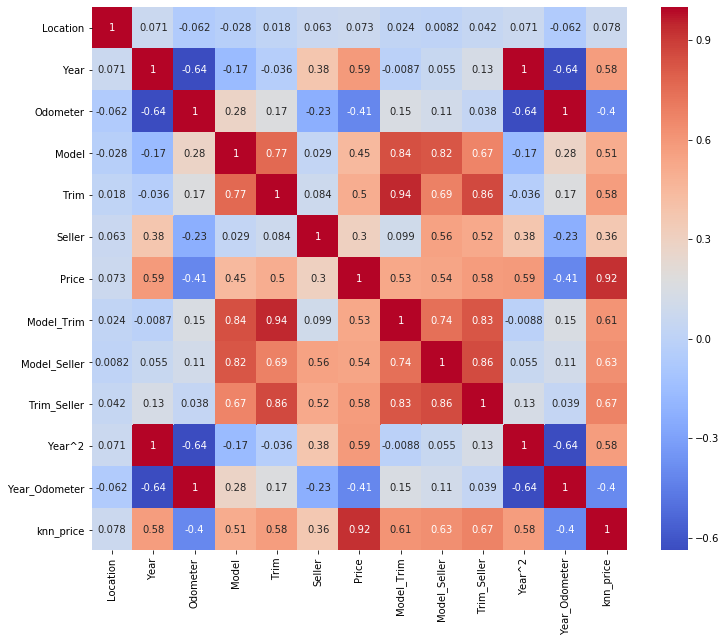

In [7]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(12,10))
sns.heatmap(train_lenc.corr(), cmap='coolwarm', annot=True)
plt.show()

<a id='section_id1'></a>

### LightGBM with category encoding

In [8]:
#Split out Price
trainX_lenc = train_lenc.copy()
trainY_lenc = trainX_lenc.pop('Price')
testX_lenc = test_lenc.copy()
testY_lenc = testX_lenc.pop('Price')

# #Drop knn_price
# trainX_lenc.drop(columns=['knn_price'], inplace=True, errors='ignore')
# testX_lenc.drop(columns=['knn_price'], inplace=True, errors='ignore')

# #From test residuals plot, drop 3 sigma outliers.
# testX_lenc.drop(index=[356,1991,8025,7189,9256,8156,2496,1093,7880,10164], inplace=True, errors='ignore')
# testY_lenc.drop(index=[356,1991,8025,7189,9256,8156,2496,1093,7880, 10164], inplace=True, errors='ignore')

In [9]:
trainX_lenc.head(2)

,Location,Year,Odometer,Model,Trim,Seller,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,knn_price
4641,14710.955882,2015,141322.0,24583.557554,17178.948864,19608.468644,16698.833333,27246.133005,19406.685851,4060225,284763830.0,24282.0
80,17495.472590,2015,171800.0,24583.557554,32367.331492,19608.468644,32780.646154,27246.133005,33378.081871,4060225,346177000.0,26884.5


In [10]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,200),
            "num_leaves": randint(2, 600), 
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfitting
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Instantiate random_search.
lgb_model = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=20, cv=10, n_jobs=-1, refit=True,\
                           scoring='neg_mean_absolute_error', return_train_score=False,random_state=42)

#Tune model with CV. Model will automatically refit on full train with best parameters.
lgb_model.fit(trainX_lenc, trainY_lenc)

#Tuned model best score.
best_score = lgb_model.best_score_
best_score_std = lgb_model.cv_results_['std_test_score'][lgb_model.best_index_]
best_hyperparams = lgb_model.best_params_
print(f'## Grid iters checked: {len(lgb_model.cv_results_["params"])}')
print(f'## best CV score: {best_score:.4f} +- {best_score_std:.4f}\n')
print('## Best parameters:')
pprint.pprint(best_hyperparams)

## Grid iters checked: 20
## best CV score: -2643.2545 +- 118.1259

## Best parameters:
{'bagging_fraction': array([0.06609683]),
 'feature_fraction': 0.3375890446041227,
 'lambda_l1': array([3.73271776e-09]),
 'lambda_l2': array([5.39247153e-06]),
 'learning_rate': array([0.04470609]),
 'max_bin': 30918,
 'max_depth': 39,
 'min_data_in_leaf': 44,
 'n_estimators': 164,
 'num_leaves': 463,
 'subsample_for_bin': 258338}


In [11]:
# #SAVE model
# joblib.dump(lgb_model, 'lgb_model.joblib', compress=0)

# #LOAD model
# lgb_model = joblib.load('lgb_model.joblib')

In [12]:
#PREDICT model.
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
y_predictions = lgb_model.predict(testX_lenc)
score_algo(lgb_model, testX_lenc, testY_lenc, y_predictions)

-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
RMSE: 4393.4
 R^2: 0.8331
 MAE: 2704.8


In [13]:
trainX_lenc.head(2)

,Location,Year,Odometer,Model,Trim,Seller,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,knn_price
4641,14710.955882,2015,141322.0,24583.557554,17178.948864,19608.468644,16698.833333,27246.133005,19406.685851,4060225,284763830.0,24282.0
80,17495.472590,2015,171800.0,24583.557554,32367.331492,19608.468644,32780.646154,27246.133005,33378.081871,4060225,346177000.0,26884.5


In [14]:
#Get feature importances using eli5.
perm = PermutationImportance(lgb_model,n_iter=4).fit(testX_lenc, testY_lenc)
eli5.show_weights(perm, feature_names = testX_lenc.columns.tolist())

Weight,Feature
1359.6004 ± 249.7037,knn_price
1318.1094 ± 163.2247,Year
1221.5338 ± 299.5643,Model
1077.9359 ± 255.1588,Year^2
451.1153 ± 100.4796,Trim
443.0681 ± 79.8355,Model_Seller
438.3588 ± 68.7387,Odometer
383.4403 ± 51.6081,Trim_Seller
301.6899 ± 64.2939,Model_Trim
199.4914 ± 55.1562,Year_Odometer


#### Residuals Plot Function

In [15]:
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots histogram.  Prints error statistics.
    '''
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),1), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    z=(error-mean)/np.std(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std
    lower_lim = mean - three_std
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,30))
    sns.set(font_scale=1.3)
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Error - True less Predicted')
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(true.iloc[elem:elem+1].index[0])  #loc
        if (y_val > upper_lim or y_val < lower_lim):
            if (elem % 2) == 0:  #even elements
                ax1.text(x=x_val+500, y=y_val-400, s=label_str, horizontalalignment = 'left', size=14, color='r')
            else:                #odd elements
                ax1.text(x=x_val-2000, y=y_val-1500, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error')
    ax2.set_ylabel('Frequency')
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('True')

In [16]:
train.head()

,Location,Year,Odometer,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,knn_price
4641,elpaso,2015,141322.0,f-250,xlt,dealer,15995.0,f-250_xlt,f-250_dealer,xlt_dealer,4060225,284763830.0,24282.0
80,austin,2015,171800.0,f-250,super duty,dealer,29997.0,f-250_super duty,f-250_dealer,super duty_dealer,4060225,346177000.0,26884.5
7475,houston,2007,104477.0,mustang,gt,dealer,6399.0,mustang_gt,mustang_dealer,gt_dealer,4028049,209685339.0,9912.4
3346,dallas,2010,107229.5,explorer,sport,owner,18969.0,explorer_sport,explorer_owner,sport_owner,4040100,215531295.0,7546.4
5499,houston,2016,84490.0,transit,cargo,dealer,17995.0,transit_cargo,transit_dealer,cargo_dealer,4064256,170331840.0,17666.9


In [17]:
# pd.set_option('max_colwidth', 200)

# #Review loc
# pd.set_option('max_colwidth', 100)
# for locNum in [1991]:
#     iloc = np.where(trainX_lenc.index==locNum)[0][0]
#     display('### modeled train:', trainX_lenc.loc[[locNum]])
#     print('true:', trainY_lenc.loc[locNum])
#     print('predicted:', y_trn_pred[iloc])
#     print('error:', trainY_lenc.loc[locNum] - y_trn_pred[iloc])
#     display('### original:', vehicle.loc[[locNum]])
#     vehicle.loc[locNum,'Body']
#     print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')

error count: 3162 | error avg: 0.0 | high pred percent: 49.4 | low pred percent: 50.6


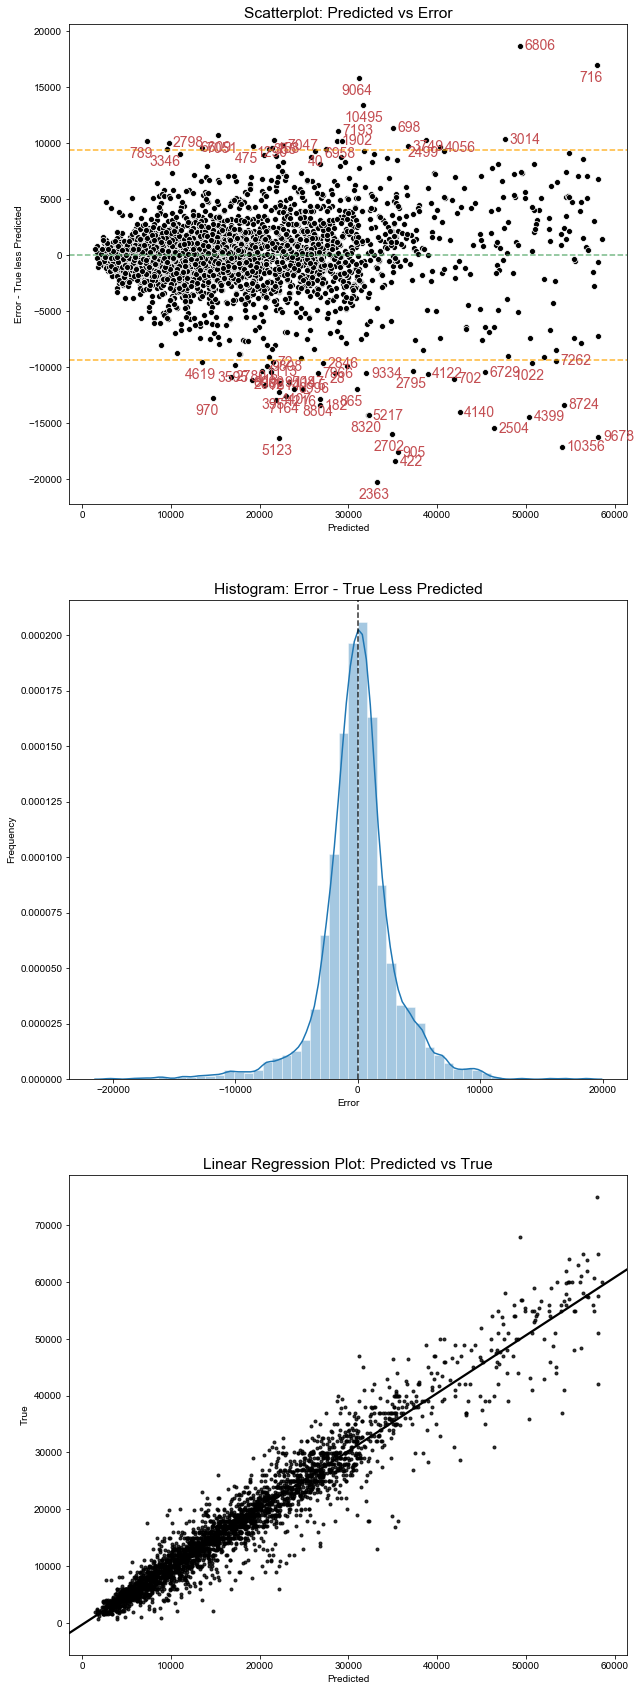

In [18]:
#Get train residuals
y_trn_pred = lgb_model.predict(trainX_lenc)
plot_residuals(predicted=y_trn_pred, true=trainY_lenc)

error count: 352 | error avg: 258.8 | high pred percent: 49.7 | low pred percent: 50.3


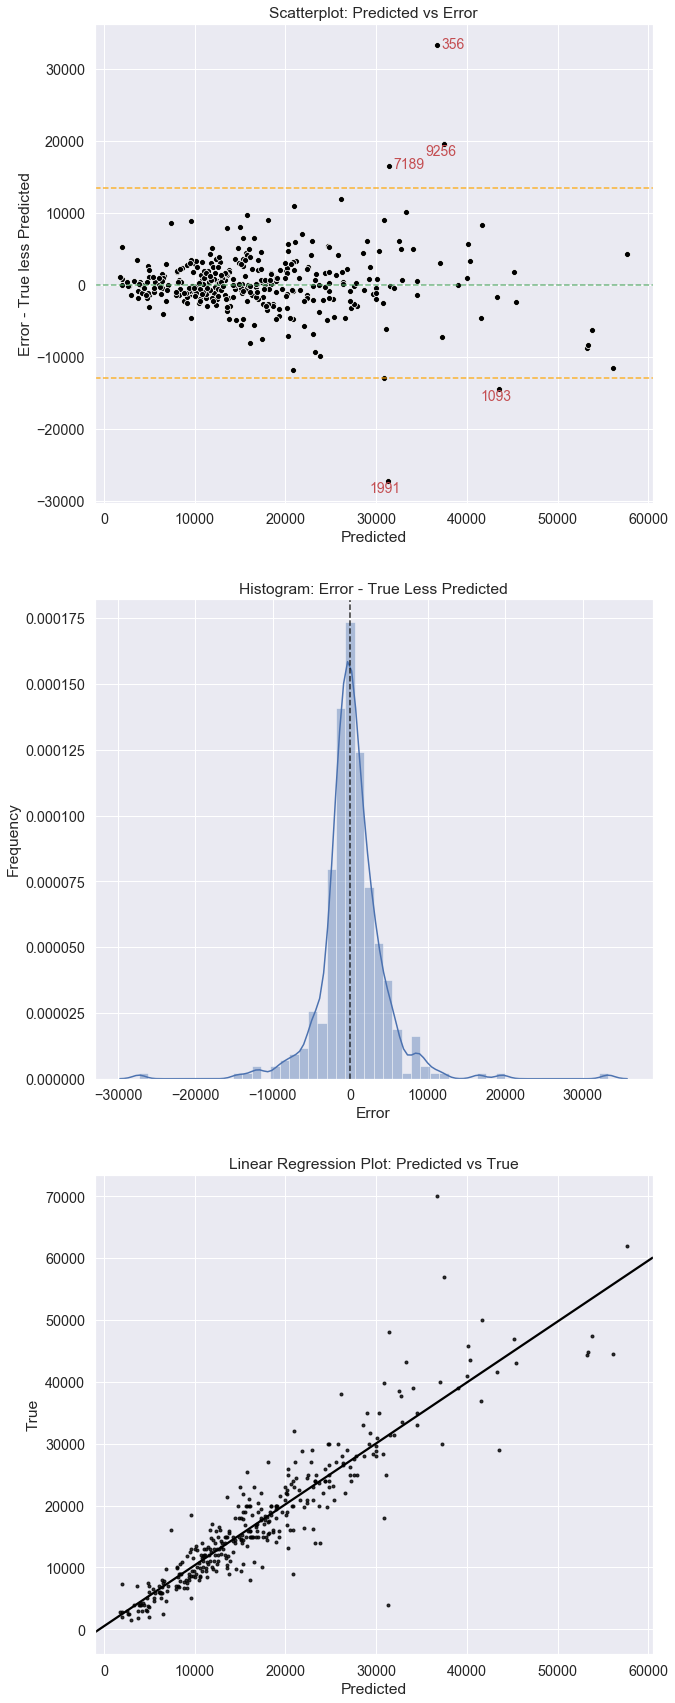

In [19]:
#Get test residuals
plot_residuals(predicted=y_predictions, true=testY_lenc)

## Linear Model data

In [20]:
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
train.index.name=None; test.index.name=None; 
train.shape

(3162, 13)

In [21]:
train.head(1)

,Location,Year,Odometer,Model,Trim,Seller,Price,Model_Trim,Model_Seller,Trim_Seller,Year^2,Year_Odometer,knn_price
4641,elpaso,2015,141322.0,f-250,xlt,dealer,15995.0,f-250_xlt,f-250_dealer,xlt_dealer,4060225,284763830.0,24282.0


In [22]:
#Split out Price
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

### One-Hot Encode

In [23]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

In [24]:
#Get One-Hot columns for the specified categ_columns.
categ_cols= trainX.select_dtypes('object').columns.values
ohe_train_df, ohe_test_df = one_hot_encode(train_df=trainX, test_df=testX, cat_cols=categ_cols)

In [25]:
print(ohe_train_df.shape)
ohe_train_df.head(2)

(3162, 163)


,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Model_crown,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_victoria,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_crown_victoria,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_crown_dealer,Model_Seller_crown_owner,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_victoria_dealer,Trim_Seller_victoria_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
4641,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [26]:
#Drop original category columns.  Concatenate the One-Hot columns.
trainX = trainX.drop(columns=categ_cols, axis='columns', errors='ignore')
testX = testX.drop(columns=categ_cols, axis='columns', errors='ignore')

trainX = pd.concat([trainX, ohe_train_df], axis='columns')
testX = pd.concat([testX, ohe_test_df], axis='columns')
display('trainX:', trainX.head(2))
display('testX:', testX.head(2))

'trainX:'

,Year,Odometer,Year^2,Year_Odometer,knn_price,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Model_crown,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_victoria,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_crown_victoria,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_crown_dealer,Model_Seller_crown_owner,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_victoria_dealer,Trim_Seller_victoria_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
4641,2015,141322.0,4060225,284763830.0,24282.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

'testX:'

,Year,Odometer,Year^2,Year_Odometer,knn_price,Location_austin,Location_dallas,Location_elpaso,Location_houston,Location_sanantonio,Model_crown,Model_edge,Model_escape,Model_expedition,Model_explorer,Model_f-150,Model_f-250,Model_f-350,Model_fiesta,Model_focus,Model_fusion,Model_mustang,Model_transit,Trim_4x4,Trim_cargo,Trim_connect,Trim_convertible,Trim_coupe,Trim_diesel,Trim_ecoboost,Trim_eddie,Trim_edge,Trim_fx2,Trim_fx4,Trim_gt,Trim_king,Trim_lariat,Trim_limited,Trim_platinum,Trim_se,Trim_sport,Trim_super,Trim_super duty,Trim_supercab,Trim_supercrew,Trim_titanium,Trim_victoria,Trim_xl,Trim_xlt,Seller_dealer,Seller_owner,Model_Trim_crown_victoria,Model_Trim_edge_edge,Model_Trim_escape_se,Model_Trim_escape_titanium,Model_Trim_expedition_eddie,Model_Trim_expedition_limited,Model_Trim_expedition_xlt,Model_Trim_explorer_limited,Model_Trim_explorer_sport,Model_Trim_explorer_xlt,Model_Trim_f-150_4x4,Model_Trim_f-150_fx2,Model_Trim_f-150_fx4,Model_Trim_f-150_king,Model_Trim_f-150_lariat,Model_Trim_f-150_platinum,Model_Trim_f-150_super,Model_Trim_f-150_supercab,Model_Trim_f-150_supercrew,Model_Trim_f-150_xl,Model_Trim_f-150_xlt,Model_Trim_f-250_diesel,Model_Trim_f-250_king,Model_Trim_f-250_lariat,Model_Trim_f-250_super,Model_Trim_f-250_super duty,Model_Trim_f-250_xlt,Model_Trim_f-350_super,Model_Trim_f-350_super duty,Model_Trim_fiesta_se,Model_Trim_focus_se,Model_Trim_fusion_se,Model_Trim_fusion_titanium,Model_Trim_mustang_convertible,Model_Trim_mustang_coupe,Model_Trim_mustang_ecoboost,Model_Trim_mustang_gt,Model_Trim_transit_cargo,Model_Trim_transit_connect,Model_Seller_crown_dealer,Model_Seller_crown_owner,Model_Seller_edge_dealer,Model_Seller_edge_owner,Model_Seller_escape_dealer,Model_Seller_escape_owner,Model_Seller_expedition_dealer,Model_Seller_expedition_owner,Model_Seller_explorer_dealer,Model_Seller_explorer_owner,Model_Seller_f-150_dealer,Model_Seller_f-150_owner,Model_Seller_f-250_dealer,Model_Seller_f-250_owner,Model_Seller_f-350_dealer,Model_Seller_f-350_owner,Model_Seller_fiesta_dealer,Model_Seller_fiesta_owner,Model_Seller_focus_dealer,Model_Seller_focus_owner,Model_Seller_fusion_dealer,Model_Seller_fusion_owner,Model_Seller_mustang_dealer,Model_Seller_mustang_owner,Model_Seller_transit_dealer,Model_Seller_transit_owner,Trim_Seller_4x4_dealer,Trim_Seller_4x4_owner,Trim_Seller_cargo_dealer,Trim_Seller_cargo_owner,Trim_Seller_connect_dealer,Trim_Seller_connect_owner,Trim_Seller_convertible_dealer,Trim_Seller_convertible_owner,Trim_Seller_coupe_dealer,Trim_Seller_coupe_owner,Trim_Seller_diesel_dealer,Trim_Seller_diesel_owner,Trim_Seller_ecoboost_dealer,Trim_Seller_ecoboost_owner,Trim_Seller_eddie_dealer,Trim_Seller_eddie_owner,Trim_Seller_edge_dealer,Trim_Seller_edge_owner,Trim_Seller_fx2_dealer,Trim_Seller_fx2_owner,Trim_Seller_fx4_dealer,Trim_Seller_fx4_owner,Trim_Seller_gt_dealer,Trim_Seller_gt_owner,Trim_Seller_king_dealer,Trim_Seller_king_owner,Trim_Seller_lariat_dealer,Trim_Seller_lariat_owner,Trim_Seller_limited_dealer,Trim_Seller_limited_owner,Trim_Seller_platinum_dealer,Trim_Seller_platinum_owner,Trim_Seller_se_dealer,Trim_Seller_se_owner,Trim_Seller_sport_dealer,Trim_Seller_sport_owner,Trim_Seller_super duty_dealer,Trim_Seller_super duty_owner,Trim_Seller_super_dealer,Trim_Seller_super_owner,Trim_Seller_supercab_dealer,Trim_Seller_supercab_owner,Trim_Seller_supercrew_dealer,Trim_Seller_supercrew_owner,Trim_Seller_titanium_dealer,Trim_Seller_titanium_owner,Trim_Seller_victoria_dealer,Trim_Seller_victoria_owner,Trim_Seller_xl_dealer,Trim_Seller_xl_owner,Trim_Seller_xlt_dealer,Trim_Seller_xlt_owner
1652,2003,167254.0,4012009,335009762.0,12635.4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## `Tune Linear Models with Cross Validation`

In [27]:
# #Drop knn_price
# trainX.drop(columns=['knn_price'], inplace=True, errors='ignore')
# testX.drop(columns=['knn_price'], inplace=True, errors='ignore')

# #From residuals plot, drop two worst outliers in test (one high, one low).
# testX.drop(index=[356,1991,7189,9256,9677,8156,674,2496], inplace=True, errors='ignore')
# testY.drop(index=[356,1991,7189,9256,9677,8156,674,2496], inplace=True, errors='ignore')

In [28]:
def train_and_valid(what_model, num_folds, X, y):
    fold_rmse=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns
        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rmse.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 2))
        
    print(f'***Tune {type(what_model).__name__}***\n## Fold RMSE:', fold_rmse)
    print('## Avg RMSE:', round(np.mean(fold_rmse),1),'+-', round(np.std(fold_rmse),1))
    print('## Clone R^2:', round(clone_model.score(X,y),3))
    return clone_model

In [29]:
#Tune LR with CV
lr=LinearRegression(fit_intercept=True)
lr_clone=train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)

***Tune LinearRegression***
## Fold RMSE: [4181.11, 4144.11, 4031.34, 4938.79, 4022.99, 3941.37, 4203.51, 4524.94, 3858.43, 3621.54]
## Avg RMSE: 4146.8 +- 347.1
## Clone R^2: 0.875


In [30]:
#Get LinearRegression feature importances.  Note: collinearity distorts feature importances.
perm = PermutationImportance(lr_clone,n_iter=2).fit(trainX, trainY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
10603.4648 ± 326.7442,Year
10509.9552 ± 62.3090,Year^2
7.5325 ± 0.2669,Year_Odometer
7.5097 ± 0.1211,Odometer
0.9951 ± 0.0448,knn_price
0.0037 ± 0.0007,Model_f-250
0.0034 ± 0.0010,Trim_Seller_se_dealer
0.0018 ± 0.0007,Trim_se
0.0017 ± 0.0003,Model_f-350
0.0010 ± 0.0007,Trim_Seller_xlt_dealer


## `Linear Model Predictions - Fit on 100% of train`

In [31]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
score_algo(linregr, testX, testY, y_pred_linregr)

-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
RMSE: 4470.9
 R^2: 0.8271
 MAE: 2981.1


error count: 352 | error avg: 78.2 | high pred percent: 51.1 | low pred percent: 48.9


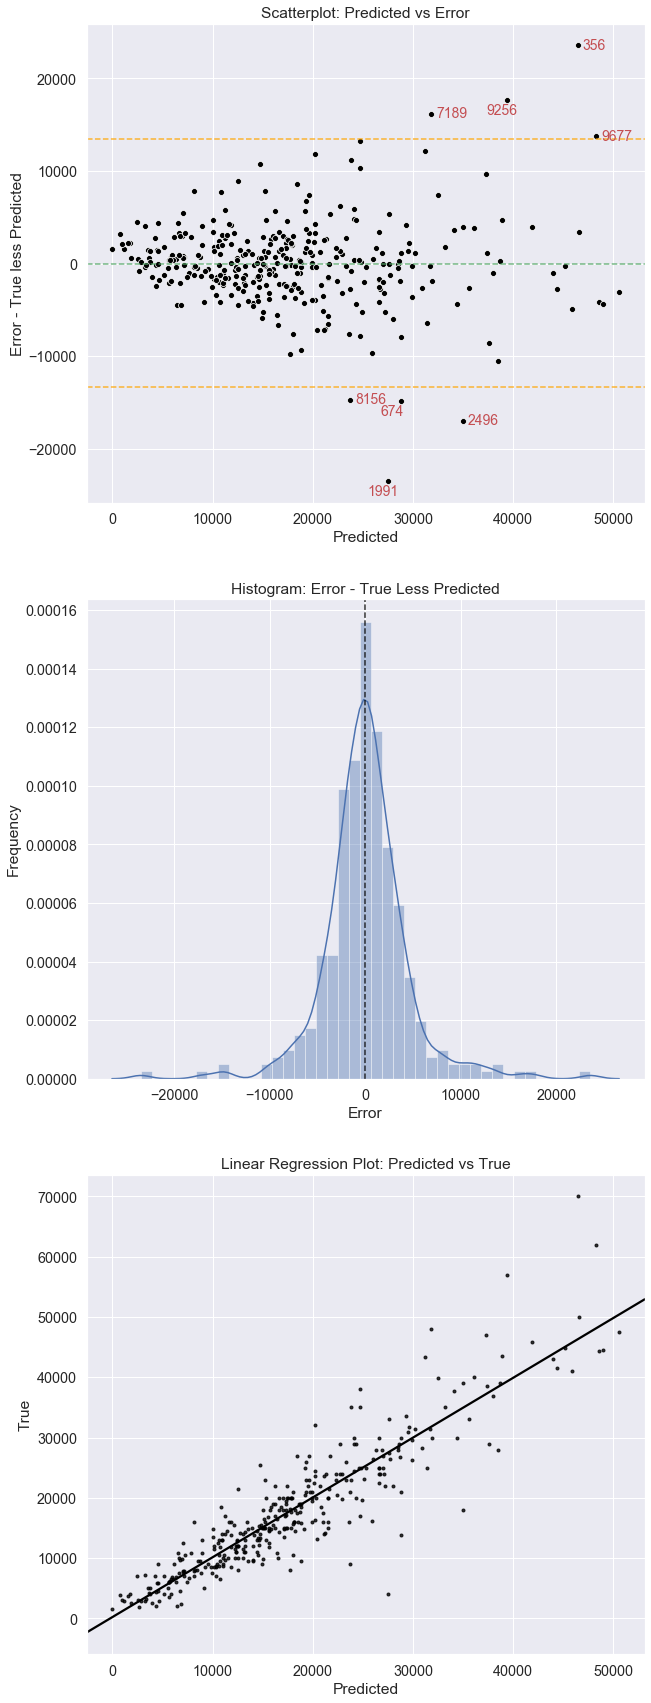

In [32]:
#Get test residuals
plot_residuals(predicted=y_pred_linregr, true=testY)